In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
ORL_PATH = "../../ORL"
train_image_array = []
train_image_labels = []
test_image_array = []
test_image_labels = []
mean_image = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(1,7):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        train_image_array.append(im2double(im).ravel())
        train_image_labels.append("s"+str(i))
        
train_image_array = np.array(train_image_array)
print(train_image_array.shape)

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(7,11):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        test_image_array.append(im2double(im).ravel())
        test_image_labels.append("s"+str(i))
        
test_image_array = np.array(test_image_array)
print(test_image_array.shape)       

(192, 10304)
(128, 10304)


In [3]:
#train_mean = np.mean(train_image_array,axis=0)
train_mean = np.zeros(train_image_array.shape[1])
for i in range(train_image_array.shape[0]):
    train_mean = train_mean + train_image_array[i,:]

train_mean = train_mean*1.0/train_image_array.shape[0]
    
#print(train_mean.shape)
train_image_array_mean = train_image_array - train_mean
#print(train_image_array_mean+train_mean == train_image_array)

L_train = np.matmul(train_image_array_mean,train_image_array_mean.T)
print(L_train.shape)

(192, 192)


In [4]:
eig_val,W = np.linalg.eig(L_train)
print(W.shape)
print(eig_val.shape)

(192, 192)
(192,)


In [5]:
print(np.matmul(W,W.T))

[[ 1.00000000e+00 -4.20084974e-15  3.53835884e-14 ...  3.03077875e-15
  -1.40431286e-14  1.27528196e-14]
 [-4.20084974e-15  1.00000000e+00  6.27102537e-16 ...  2.71484224e-15
  -8.17908566e-15 -6.87817858e-16]
 [ 3.53835884e-14  6.27102537e-16  1.00000000e+00 ... -8.79591538e-15
   7.55103445e-15  8.04347908e-15]
 ...
 [ 3.03077875e-15  2.71484224e-15 -8.79591538e-15 ...  1.00000000e+00
  -5.00982719e-15 -4.16333634e-16]
 [-1.40431286e-14 -8.17908566e-15  7.55103445e-15 ... -5.00982719e-15
   1.00000000e+00 -3.91098829e-15]
 [ 1.27528196e-14 -6.87817858e-16  8.04347908e-15 ... -4.16333634e-16
  -3.91098829e-15  1.00000000e+00]]


In [6]:
V = np.matmul(train_image_array_mean.T,W)
_,c = V.shape
for i in range(c):
    V[:,i] = V[:,i]/(np.sqrt(np.sum(np.square(V[:,i]))))

print(V.shape)
#print(np.linalg.norm(V[:,2]))

(10304, 192)


In [7]:
alpha = np.dot(V.T,train_image_array_mean.T)
print("Shape of alpha ",alpha.shape)
alpha_1 = alpha.T[0]
#print(alpha_1)

Shape of alpha  (192, 192)


In [8]:
test_image_array_mean = test_image_array - train_mean
alpha_test = np.matmul(V.T,test_image_array_mean.T)
print("alpha_test shape ",alpha_test.shape)

# Project each image on eigen-space and find the closest image in terms of minimum squared difference of alpha_test and other alphas.
ks = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
prediction_rate = [] #for each k

#pick one group from the test set and compare each element of it with the other group
for k in ks:
    correct_prediction_count = 0
    for counter, ele in enumerate(alpha_test.T):
        temp_diff_alphas = []
        for i, a in enumerate(alpha.T):
            alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
            temp_diff_alphas.append(np.sum( np.square(alpha.T[i] - alpha_test_padded )))
        index = np.argmin(temp_diff_alphas)
        if (counter//4 == index//6):
            correct_prediction_count += 1
    prediction_rate.append(correct_prediction_count/float(test_image_array_mean.shape[0]))

alpha_test shape  (192, 128)


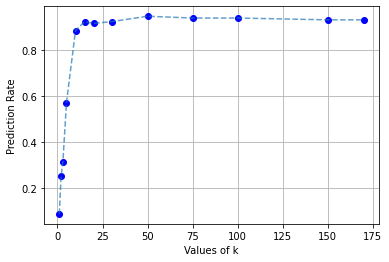

In [9]:
plt.plot(ks,prediction_rate,"bo")
plt.plot(ks,prediction_rate,alpha=0.7,linestyle='dashed')
#plt.axis([0, 1, 0, 200]) # range of x and y axis
plt.ylabel('Prediction Rate')
plt.xlabel('Values of k')
plt.grid()
plt.show()

In [10]:
#alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
#print(alpha_test_padded)
print(np.sum(np.square(alpha_test.T[counter]-alpha.T[counter])))

736.1785403498792


In [11]:
# SVD 
print(train_image_array_mean.shape)
U,sigma,V_T = np.linalg.svd(train_image_array_mean.T,full_matrices=False)
print(U.shape)

(192, 10304)
(10304, 192)


In [12]:
_,c = U.shape
for i in range(c):
    U[:,i] = U[:,i]/(np.sqrt(np.sum(np.square(U[:,i]))))

In [13]:
#print(np.matmul(U,U.T))
alpha_svd =np.matmul(U.T,train_image_array_mean.T)
print("Shape of alpha ",alpha_svd.shape)
alpha_1_svd = alpha_svd.T[0]

Shape of alpha  (192, 192)


In [14]:
alpha_svd_test = np.matmul(U.T,test_image_array_mean.T)
print("alpha_test shape ",alpha_svd_test.shape)

alpha_test shape  (192, 128)


In [15]:
ks = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
prediction_rate = [] #for each k

#pick one group from the test set and compare each element of it with the other group
for k in ks:
    correct_prediction_count = 0
    for counter, ele in enumerate(alpha_test.T):
        temp_diff_alphas = []
        for i, a in enumerate(alpha.T):
            alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
            temp_diff_alphas.append(np.sum( np.square(alpha.T[i] - alpha_test_padded )))
        index = np.argmin(temp_diff_alphas)
        if (counter//4 == index//6):
            correct_prediction_count += 1
    prediction_rate.append(correct_prediction_count/float(test_image_array_mean.shape[0]))

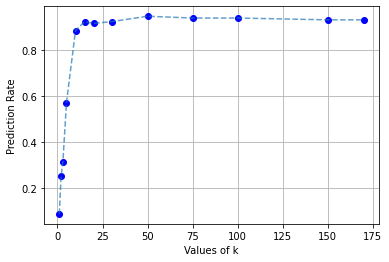

In [16]:
plt.plot(ks,prediction_rate,"bo")
plt.plot(ks,prediction_rate,alpha=0.7,linestyle='dashed')
#plt.axis([0, 1, 0, 200]) # range of x and y axis
plt.ylabel('Prediction Rate')
plt.xlabel('Values of k')
plt.grid()
plt.show()

In [17]:
YALE_PATH = "../../CroppedYale"
train_image_array = []
train_image_labels = []
test_image_array = []
test_image_labels = []
mean_image = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

folder_list = os.listdir(YALE_PATH)
for i in folder_list:
    folder_path = os.path.join(YALE_PATH,i)
    files = os.listdir(folder_path)
    for j in files[:40]:
        filepath = os.path.join(folder_path,j)
        im = cv2.imread(filepath,0)
        train_image_array.append(im2double(im).ravel())
        train_image_labels.append(i[-2:])
        
train_image_array = np.array(train_image_array)
print(train_image_array.shape)

for i in folder_list:
    folder_path = os.path.join(YALE_PATH,i)
    files = os.listdir(folder_path)
    for j in files[40:]:
        filepath = os.path.join(folder_path,j)
        im = cv2.imread(filepath,0)
        test_image_array.append(im2double(im).ravel())
        test_image_labels.append(i[-2:])
        
test_image_array = np.array(test_image_array)
print(test_image_array.shape)       

(1520, 32256)
(895, 32256)


In [ ]:

train_mean = np.zeros(train_image_array.shape[1])
for i in range(train_image_array.shape[0]):
    train_mean = train_mean + train_image_array[i,:]

train_mean = train_mean*1.0/train_image_array.shape[0]
    
#print(train_mean.shape)
train_image_array_mean = train_image_array - train_mean
#print(train_image_array_mean+train_mean == train_image_array)

L_train = np.matmul(train_image_array_mean,train_image_array_mean.T)
print(L_train.shape)

eig_val,W = np.linalg.eig(L_train)
print(W.shape)
print(eig_val.shape)

V = np.matmul(train_image_array_mean.T,W)
_,c = V.shape
for i in tqdm(range(c),desc="Normalizing V"):
    V[:,i] = V[:,i]/(np.sqrt(np.sum(np.square(V[:,i]))))

print(V.shape)

alpha = np.dot(V.T,train_image_array_mean.T)
print("Shape of alpha ",alpha.shape)
alpha_1 = alpha.T[0]

test_image_array_mean = test_image_array - train_mean
alpha_test = np.matmul(V.T,test_image_array_mean.T)
print("alpha_test shape ",alpha_test.shape)

In [27]:
# Project each image on eigen-space and find the closest image in terms of minimum squared difference of alpha_test and other alphas.
from tqdm import tqdm
ks = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 200, 300, 500, 1000]
prediction_rate = [] #for each k

#pick one group from the test set and compare each element of it with the other group
for k in tqdm(ks,desc="k values"):
    correct_prediction_count = 0
    for counter, ele in enumerate(alpha_test.T):
        temp_diff_alphas = []
        #alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
        index = np.argmin(np.sum(np.square((alpha.T[:,3:3+k]-alpha_test.T[counter,3:3+k])),axis=1))
#         for i, a in enumerate(alpha.T):
#             alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
#             temp_diff_alphas.append(np.sum( np.square(alpha.T[i] - alpha_test_padded )))
#         index = np.argmin(temp_diff_alphas)
        if (counter//24 == index//40):
            correct_prediction_count += 1
    prediction_rate.append(correct_prediction_count/float(test_image_array_mean.shape[0]))

k values: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


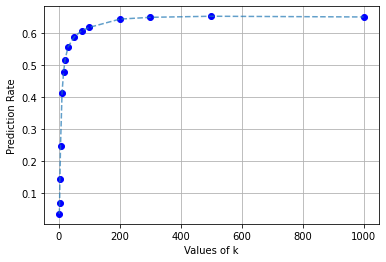

In [28]:
plt.plot(ks,prediction_rate,"bo")
plt.plot(ks,prediction_rate,alpha=0.7,linestyle='dashed')
#plt.axis([0, 1, 0, 200]) # range of x and y axis
plt.ylabel('Prediction Rate')
plt.xlabel('Values of k')
plt.grid()
plt.show()

In [26]:
print(index)
alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
index = np.argmin(np.sum(np.square((alpha.T-alpha_test_padded)),axis=1))
print(index)

1487
1487
